在本教程中，我们将更深入地了解如何将图神经网络（GNN）应用于图分类任务。图分类是指在给定图的数据集的情况下，基于一些结构图的属性对整个图（与节点相反）进行分类的问题。在这里，我们想要嵌入整个图，并且我们想要以这样一种方式嵌入这些图，即在给定手头的任务的情况下，它们是线性可分离的。

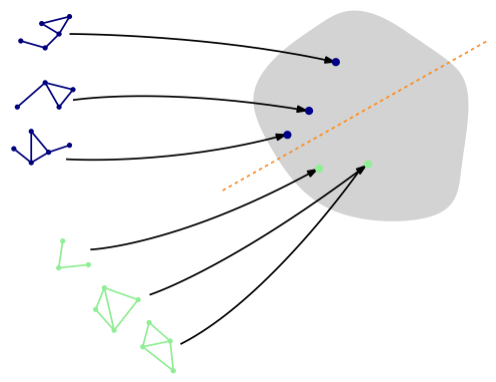

### 1.数据集介绍及划分

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;图分类最常见的任务是**分子性质预测**，其中分子被表示为图，该任务可能是推断分子是否抑制HIV病毒复制。多特蒙德工业大学（The TU Dortmund University）收集了一系列不同的图分类数据集，称为[**TUDatasets**](https://chrsmrrs.github.io/datasets/)，这些数据集也可以通过`PyTorch Geometric`中的[`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset) 访问。让我们加载并检查其中一个较小的数据集，即**MUTAG dataset**：

In [1]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[1] # 获取第一个图对象
print()
print(data)
print('=============================================================')

# 获取第一张图的统计数据
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])
Number of nodes: 13
Number of edges: 28
Average node degree: 2.15
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [2]:
print(data.x)
print(data.edge_attr)
print(data.y)

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1.

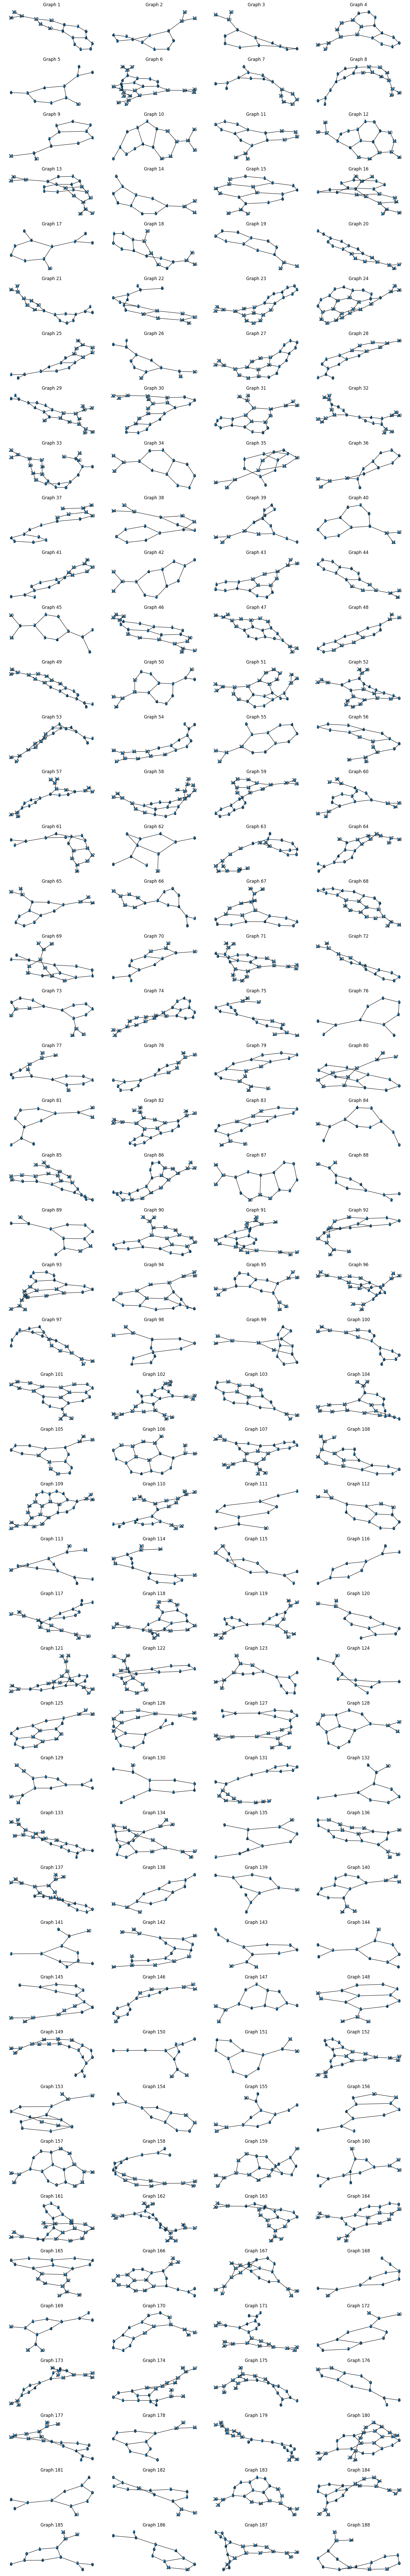

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建一个图形窗口
fig, axes = plt.subplots(nrows=47, ncols=4, figsize=(16, 100))

# 在每个子图中绘制一个图
for i, data in enumerate(dataset):
    row, col = divmod(i, 4)
    
    # 创建图对象
    G = nx.Graph()

    # 添加节点
    G.add_nodes_from(range(data.x.shape[0]))

    # 添加边
    edge_index = data.edge_index.numpy()
    G.add_edges_from(edge_index.T)

    # 绘制图形
    pos = nx.spring_layout(G) 
    nx.draw(G, pos, ax=axes[row, col], with_labels=True, node_size=40)
    axes[row, col].set_title(f'Graph {i+1}')

# 调整布局
plt.tight_layout()
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;该数据集提供了188个不同的图，任务是将每个图分类为两类中的一类。</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<font color=blue>通过检查数据集的第一个图对象，我们可以看到它有17个节点（具有7维特征向量）和38条边（导致平均节点度为2.24）。它还只附带了一个图标签（y=[1]），并且除了以前的数据集之外，还提供了附加的4维边缘特征（edge_attr=[38，4]）。然而，为了简单起见，我们不会使用这些。</font></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`PyTorch Geometric`为处理图形数据集提供了一些有用的实用程序，例如，我们可以对数据集进行打乱，并使用前150个图形作为训练图，同时使用其余的图形进行测试：

In [4]:
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


### 2.数据集加载

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;由于图分类数据集中的图通常很小，因此一个好主意是在将图输入到图神经网络之前对图进行批处理，以确保GPU的充分利用。在图像或语言领域，此过程通常通过将每个示例重新缩放或填充为一组大小相等的形状来实现，然后将示例分组为附加维度。该维度的长度等于小批量中分组的示例数，通常称为`batch_size`。

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;然而，对于`GNN`，上述两种方法要么不可行，要么可能导致大量不必要的内存消耗。因此，`PyTorch Geometric`选择了另一种方法来实现跨多个示例的并行化。**这里，邻接矩阵以对角线的方式堆叠（创建一个包含多个孤立子图的巨型图），节点和目标特征在节点维度中简单地连接**：

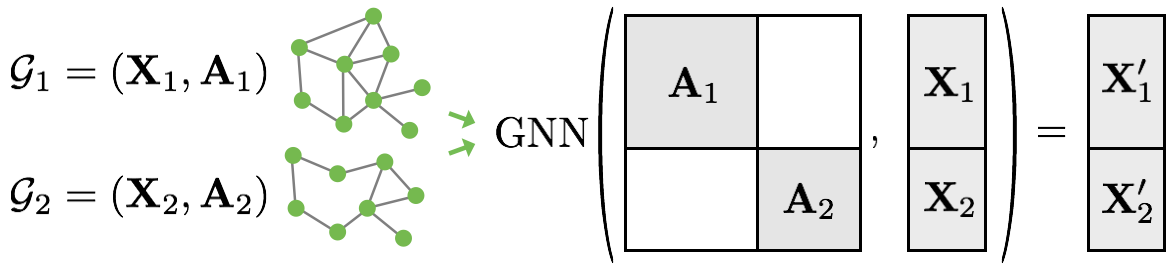

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;与其它batching程序相比，该程序具有一些关键优势：

1. 依赖于消息传递方案的GNN运算符不需要修改，因为属于不同图的两个节点之间不交换消息。

2. 没有计算或内存开销，因为邻接矩阵是以稀疏的方式保存的，只包含非零条目，即边缘。

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;通过[`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) 类，`PyTorch Geometric`自动**将多个图批处理为单个巨型图** ：

In [5]:
def visualize(data):
    G = nx.Graph()
    
    edge_index = data.edge_index.numpy()
    G.add_edges_from(edge_index.T)
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, font_weight='bold', node_size=10, node_color='skyblue', font_size=8)
    
    plt.figure(figsize=(600,200))
    plt.tight_layout()
    plt.show()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2526], x=[1149, 7], edge_attr=[2526, 4], y=[64], batch=[1149], ptr=[65])



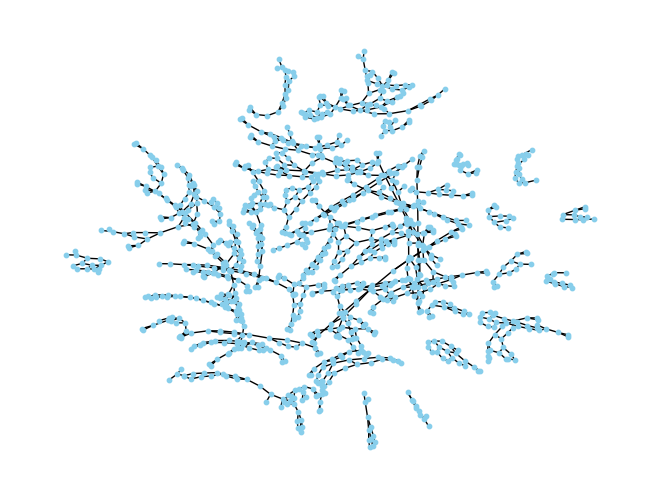

<Figure size 60000x20000 with 0 Axes>

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2420], x=[1102, 7], edge_attr=[2420, 4], y=[64], batch=[1102], ptr=[65])



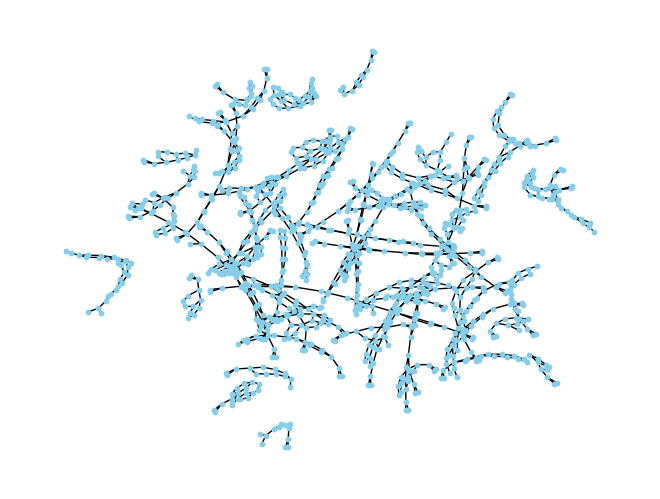

<Figure size 60000x20000 with 0 Axes>

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 864], x=[394, 7], edge_attr=[864, 4], y=[22], batch=[394], ptr=[23])



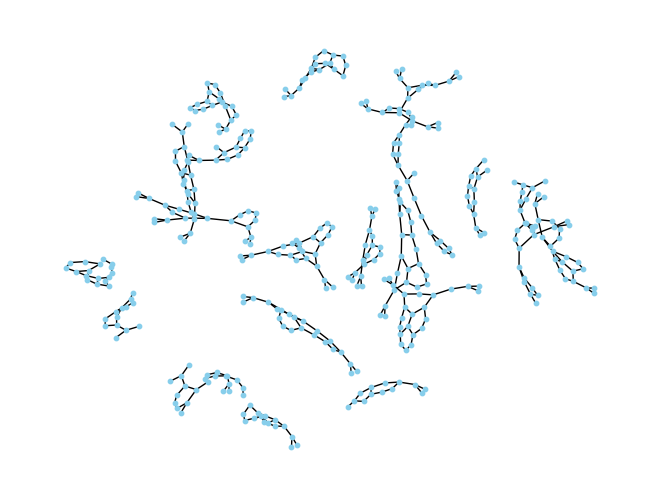

<Figure size 60000x20000 with 0 Axes>

In [6]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

    visualize(data)

### 3.训练一个图神经网络（GNN）

训练用于图分类的GNN通常遵循一个简单的方案：

1. 通过执行多轮消息传递嵌入每个节点
2. 将节点嵌入聚合到统一图嵌入中 (**readout layer**)
3. 在图嵌入上训练最终分类器

文献中存在多个**readout layer**，但最常见的是简单地取节点嵌入的平均值：
$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import global_mean_pool

class GATv2(nn.Module):
    def __init__(self, output_channels=2):
        super(GATv2, self).__init__()

        self.conv1 = GATv2Conv(dataset.num_node_features, 64, heads=4, concat=False)        
        self.conv2 = GATv2Conv(64, 32, heads=2, concat=False)
        
        self.classifier = nn.Linear(32, output_channels)

    def forward(self, x, edge_index, batch):
        
        x = F.relu(self.conv1(x, edge_index)) # (num_nodes, num_features) ——> (num_nodes, num_features=64)
        x = F.relu(self.conv2(x, edge_index)) # (num_nodes, num_features=64) ——> (num_nodes, dataset.num_classes=32)
        
        x = global_mean_pool(x, batch) # (num_nodes, num_features=32) ——> (batch_size, num_features=32)
        
        x = F.dropout(x, p=0.4, training=self.training)
        
        x = self.classifier(x) # (batch_size, 32) ——> (batch_size, datasets_number_categories)

        return x

model = GATv2()
print(model)

# 统计模型总参数量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

GATv2(
  (conv1): GATv2Conv(7, 64, heads=4)
  (conv2): GATv2Conv(64, 32, heads=2)
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)
Total parameters: 12898


In [8]:
def train(): 
    model.train() # 训练模式
    
    train_loss = 0.0  # 一个epoch，所有样本损失总和
    
    # 每个Mini-batch更新一次参数
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()  # 梯度清0
        outputs = model(data.x, data.edge_index, data.batch)  # 前向传播
        loss = criterion(outputs, data.y)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 参数更新
        
        train_loss += loss.item()
    
    return train_loss * 1.0 / len(train_dataset) # 一个epoch，训练数据集所有样本平均损失
    
def test(loader):    
    model.eval() # 测试模式
    
    correct = 0
    for data in loader:
        data = data.to(device)
        outputs = model(data.x, data.edge_index, data.batch)  # 预测输出
        preds = outputs.argmax(dim=1) # 测试预测
        correct += int((preds == data.y).sum()) # 预测正确样本数
        
    return correct / len(loader.dataset) # 准确率

In [9]:
import time
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 使用GPU or CPU

model = model.to(device) # 加载模型
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4) # 优化器
criterion = nn.CrossEntropyLoss(reduction='sum')  # 损失函数

data = data.to(device)

start_time = time.time()

for epoch in range(201):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    if epoch % 20 == 0:
        print('Epoch #{:03d}, Loss: {:.4f}, Train_Accuracy: {:.4f}, Test_Accuracy: {:.4f}'.format(epoch, loss, train_acc, test_acc))
        
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Epoch #000, Loss: 0.6855, Train_Accuracy: 0.6333, Test_Accuracy: 0.7895
Epoch #020, Loss: 0.5499, Train_Accuracy: 0.7267, Test_Accuracy: 0.8158
Epoch #040, Loss: 0.5461, Train_Accuracy: 0.7467, Test_Accuracy: 0.8158
Epoch #060, Loss: 0.5332, Train_Accuracy: 0.7533, Test_Accuracy: 0.8421
Epoch #080, Loss: 0.5172, Train_Accuracy: 0.7600, Test_Accuracy: 0.8158
Epoch #100, Loss: 0.5402, Train_Accuracy: 0.7600, Test_Accuracy: 0.8421
Epoch #120, Loss: 0.5542, Train_Accuracy: 0.7467, Test_Accuracy: 0.7632
Epoch #140, Loss: 0.5159, Train_Accuracy: 0.7467, Test_Accuracy: 0.7895
Epoch #160, Loss: 0.5094, Train_Accuracy: 0.7600, Test_Accuracy: 0.8421
Epoch #180, Loss: 0.5211, Train_Accuracy: 0.7467, Test_Accuracy: 0.8684
Epoch #200, Loss: 0.5157, Train_Accuracy: 0.7533, Test_Accuracy: 0.8947
Elapsed time: 15.668480396270752 seconds
